# 真正的图像增强扩充数据集调优
by 刘道会

2010-9于重庆大学

之前的图像处理主要是做了图像的裁剪和平移，这两个操作对于训练来讲可以说是必需的，否则数据集的质量就太差了，如前工作，网络已经可以正常训练工作了，但精度只有80%左右（validate_main2.py)，现在做一些真正的数据增强操作，包括旋转，缩放等（当然还是局限于GG-CNN范围内，，把这块工作做完的话，后面就真正开始自己独立的内容添加了。

这部分内容的修改主要围绕几个图像类，抓取类以及数据集类来实现，具体操作就是在抓取类和图像类里面添加可以实现旋转缩放的函数功能，然后在数据集载入类里面调用这些功能实现效果。

开整！

## 1.对图像类功能的添加

### 1.1 Image 类
先直接照搬原先的image_pro内容

In [1]:
from imageio import imread

from skimage.transform import resize,rotate

原来定义的，没有添加旋转和缩放操作的Image类可以参考之前章节的image_pro.py文件，下面直接就在以前的基础上为Image这个类添加了旋转的功能

In [2]:
class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(imread(file_path))
    
    def img_format(self):
        '''
        :功能 :将原始图像转换为指定格式
        '''
        pass
    
    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[0,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()
        
    def crop(self,top_left, bottom_right):
        '''
        :功能              :按照给定参数对图像进行裁剪操作
        :参数 top_left     :ndarray,要裁剪区域的左上角点坐标
        :参数 bottom_right :ndarray,要裁剪区域的右下角点坐标
        '''
        self.img = self.img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    
    def resize(self,shape):
        '''
        :功能           :将图片resize成指定的shape
        :参数 shape     :ndarray,要裁剪区域的左上角点坐标
        '''
        if self.img.shape == shape:
            return
        self.img = resize(self.img, shape, preserve_range=True).astype(self.img.dtype)
    
    def rotate(self,angle,center = None):
        '''
        :功能           :将图片绕指定中心逆时针旋转指定角度
        :参数 angle     :要旋转的角度（弧度制）
        :参数 center    :旋转中心像素坐标，如不指定则默认为图像中心像素坐标
        '''
        if center is not None:
            center = (int(center[0]),int(center[1]))#不管你原来什么数据类型，这里都变成tuple,而且这边不转整型的话后面旋转就会出错，所以转换了一下
        self.img = rotate(self.img,angle/np.pi*180,center = center,mode = 'symmetric',preserve_range = True).astype(self.img.dtype)

这就定义完了旋转的函数，按照我这么谨慎的性格，应该写一个测试一个，干。

In [3]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

cornell_path = "../cornell"
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

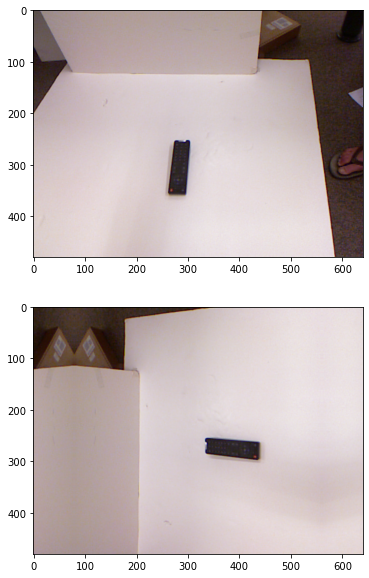

In [4]:
img = Image.from_file(rgbf[0])

plt.figure(figsize = (10,10))

plt.subplot(211)
plt.imshow(img.img)
plt.subplot(212)
img.rotate(1.57)#弧度制，pi是3.14，对应180°，这里1.57就是近似90°
plt.imshow(img.img)
plt.show()

获取一下这张图片的裁剪参数，按照ggcnn的顺序，先旋转后裁剪试试

In [5]:
#获取裁剪参数
from grasp_pro import Grasps
output_size = 300
def _get_crop_attrs(idx):
    gtbbs = Grasps.load_from_cornell_files(graspf[idx])
    center = gtbbs.center
    left = max(0, min(center[1] - output_size // 2, 640 - output_size))
    top = max(0, min(center[0] - output_size // 2, 480 - output_size))
    return center, left, top

center, left, top = _get_crop_attrs(0)

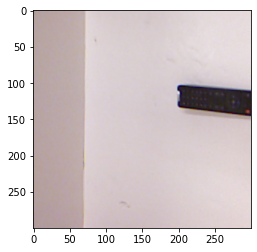

In [6]:
img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))
plt.imshow(img.img)
plt.show()

显然，失败了，我就觉得你这顺序有问题，旋转过后，目标对象的位置肯定变了，你再按照原来的方框坐标去裁剪，肯定不对劲啊，应该先裁剪，再旋转，就没问题，但是ggcnn的顺序是先旋转后裁剪，最后的训练也是成功的，所以我决定探究一下为什么他那边没问题。

![atyl.jpg](..\images\atyl.jpg)

好了，找到原因了，关键在于rot时候有没有指定中心点这个参数，如果不指定旋转的中心，图像默认就会以整个图像的中心为旋转中心来进行旋转，这对象可能就被转到其他地方去了，再裁剪肯定不对，但是，我们前面已经求出了对象的中心，如果我们以对象的中心为中心进行旋转的话，怎么转对象都还是在图像的中心的，还是按照原先的裁剪参数裁剪就不会出问题，问题解决。

要修改的地方就只有两处，一是在旋转之前使用_get_grop_attrs()获取一下中心点，然后旋转的时候以对象的中心为中心旋转即可

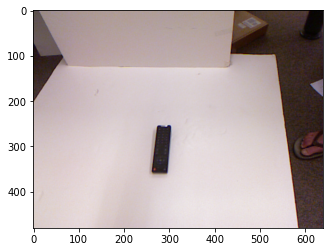

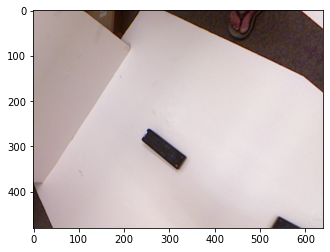

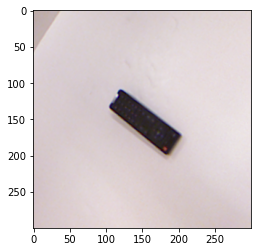

In [7]:
#读入图片
img = Image.from_file(rgbf[0])
plt.imshow(img.img)
plt.show()

#获取中心坐标和角点坐标参数
center, left, top = _get_crop_attrs(0)

#以对象中心为中心旋转
img.rotate(1,center = center)
plt.imshow(img.img)
plt.show()

#裁剪图片
img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))

plt.imshow(img.img)
plt.show()

深度图的旋转跟这一样，就是直接继承的这个类，直接展示一下效果

In [8]:
class DepthImage(Image):
    '''深度图像类，读取，载入，正则等预处理都是一样的，后面可能会添加一些针对深度图的专属处理功能'''
    def __init__(self,img):
        super(DepthImage,self).__init__(img)  

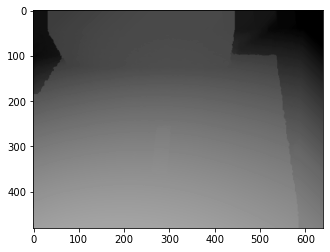

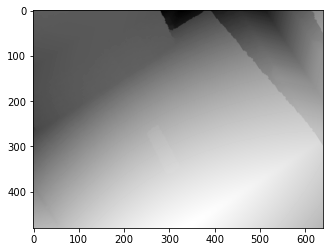

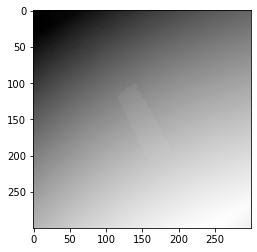

In [9]:
#读入图片
d_img = DepthImage.from_file(depthf[0])
plt.imshow(d_img.img,cmap=plt.cm.gray_r)
plt.show()

#获取中心坐标和角点坐标参数
center, left, top = _get_crop_attrs(0)

#以对象中心为中心旋转
d_img.rotate(0.57,center = center)
plt.imshow(d_img.img,cmap=plt.cm.gray_r)
plt.show()

#裁剪图片
d_img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))

plt.imshow(d_img.img,cmap=plt.cm.gray_r)
plt.show()

上面已经把图像旋转的功能添加到类里面去了，新的文件保存在本目录，名字为image_pro.py

下面一步就是把标注也转过来使其保持统一，因为我们的标注也是图片，所以一个很直观的想法就是，先生成标注图片，然后直接对那个图片进行变换就行了。而不是对原始坐标角点层面的数据做什么处理。

但有一个问题，就是我们的标注图像是直接生成的300$\times$300的，这就相当先裁剪过了的，后面再旋转的话，旋转任意角度，图像会失真的，所以说，这里有两种办法：
- 1.直接按照原始的图片大小生成标注图像，然后对其进行同样的先旋转后裁剪的操作；
- 2.预先对定义抓取框的角点进行处理，使之跟旋转裁剪等变换之后的图像位置保持一致，然后再用这些角点直接生成所需要大小的标注图像。

ggcnn用的是方法二，我这里稍微想一想也是觉得使用方法2好一点，因为生成指定大小图片的程序已经写好了，而且处理完之后，直接生成最终符合要求的标注图像是最节省时间的。

干！

这就需要对之前定义的grasp类添加旋转功能了，一个矩形都能旋转出结果，更何况矩形的四个角点。

## 2.对标注类旋转功能的添加
思路是这样的，，，昨天写到这里就离开去做其他事了，所以我也忘了当时想写啥了，不过不管了，直接照抄GGCNN得了

由于原先关于Grasp这个类的定义太长了，这里就不重新写了，直接就写新增的这一段了，后面使用测试的时候，导入测试即可

In [10]:
class Grasp:
    def __init__(self):
        pass
    
    def rotate(self,angle,center):
        '''
        :功能        ：将抓取标注矩形按照给定的旋转角度和旋转中心进行逆时针旋转
        :参数 angle  ：要旋转的角度（弧度制）
        :参数 center ：旋转中心
        '''
        #定义旋转矩阵,注意，我这边的定义跟GGCNN的差一个负号
        R = np.array(
            [
                [np.cos(angle), np.sin(angle)],
                [-1 * np.sin(angle), np.cos(angle)],
            ]
        )
        #处理旋转中心
        c = np.array(center).reshape((1, 2))
        #执行旋转运算
        self.points = ((np.dot(R, (self.points - c).T)).T + c).astype(np.int)

实际用的时候上面这个简化版本是用不了的，还是从文件中导入吧

In [11]:
from grasp_pro import Grasps,Grasp

grs = Grasps.load_from_cornell_files(graspf[0])
gr = grs.grs[0]

In [12]:
gr.rotate(-0.57,center)

绘制出来看看效果如何，对不对

In [13]:
gr.points

array([[248, 299],
       [293, 333],
       [277, 354],
       [232, 320]])

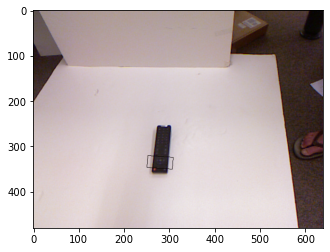

In [14]:
import cv2

#载入原始图片和原始抓取框
rgb_img = Image.from_file(rgbf[0])
grs = Grasps.load_from_cornell_files(graspf[0])
gr = grs.grs[0]
for i in range(3):
    cv2.line(rgb_img.img,tuple(gr.points[i]),tuple(gr.points[i+1]),5)
rgb_img.img = cv2.line(rgb_img.img,tuple(gr.points[3]),tuple(gr.points[0]),5) 

#展示这个框的原始结果
plt.imshow(rgb_img.img)
plt.show()

完全Ojbk！

给两者都应用旋转

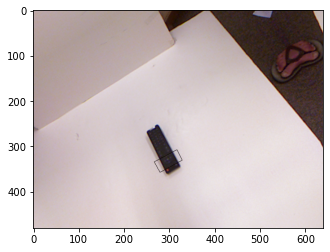

In [15]:
#这个图像需要重新读一下，否则会带着上面画的框
rgb_img = Image.from_file(rgbf[0])
rgb_img.rotate(0.57,center)
 
gr.rotate(0.57,center)
for i in range(3):
    cv2.line(rgb_img.img,tuple(gr.points[i]),tuple(gr.points[i+1]),5)
rgb_img.img = cv2.line(rgb_img.img,tuple(gr.points[3]),tuple(gr.points[0]),5) 
#展示旋转后的结果
plt.imshow(rgb_img.img)
plt.show()

加上裁剪再旋转试试，这时候标注框就得平移了，它没法裁剪，这个之前定义裁剪的时候就讲过

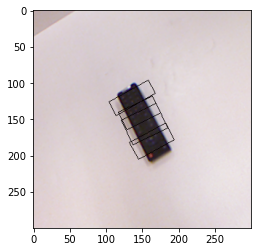

In [16]:
#载入原始图片和原始抓取框
rgb_img = Image.from_file(rgbf[0])
grs = Grasps.load_from_cornell_files(graspf[0])
gr = grs.grs[0]

#给图像应用旋转和裁剪
rgb_img.rotate(0.57,center)
rgb_img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))

#给抓取框应用旋转和平移并绘制结果
for gr in grs.grs:
    gr.rotate(0.57,center)
    gr.offset((-top,-left))
    for i in range(3):
        cv2.line(rgb_img.img,tuple(gr.points[i]),tuple(gr.points[i+1]),5)
    rgb_img.img = cv2.line(rgb_img.img,tuple(gr.points[3]),tuple(gr.points[0]),5) 

#展示结果
plt.imshow(rgb_img.img)
plt.show()

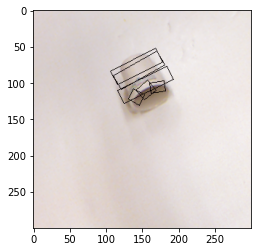

In [17]:
#换几个编号试试其他的有没有问题
#载入原始图片和原始抓取框
rgb_img = Image.from_file(rgbf[222])
grs = Grasps.load_from_cornell_files(graspf[222])

#给图像应用旋转和裁剪
rgb_img.rotate(0.57,center)
rgb_img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))

#给抓取框应用旋转和平移并绘制结果
for gr in grs.grs:
    gr.rotate(0.57,center)
    gr.offset((-top,-left))
    for i in range(3):
        cv2.line(rgb_img.img,tuple(gr.points[i]),tuple(gr.points[i+1]),5)
    rgb_img.img = cv2.line(rgb_img.img,tuple(gr.points[3]),tuple(gr.points[0]),5) 

#展示结果
plt.imshow(rgb_img.img)
plt.show()

完美，至此，旋转解决。

## 3.对图像类缩放功能的添加

这里也一样，直接就定义一个简化版本的Image类，完整的定义见本目录下的image_pro.py文件。

但是这里对于缩放这个功能的表述还是要讲一下，因为我们最终输入给网络的数据肯定是（output_size，output_size）大小的，所以，你缩放之后，还是要再resize回来才行，这样可能有些人不明白，最后输入的不还是原先的图吗，缩放和resize有什么区别，其实是有区别的，主要体现在像素上，一个图片你先缩小，后面再resize变大，肯定是要变模糊的，开干，等会看到效果就知道了。

In [18]:
class Image:
    def __init__(self):
        pass
    
    def zoom(self,factor):
        '''
        :功能        ：通过裁剪和resize来实现缩放操作，注意，缩放并不是直接一个函数一步实现的
        :参数 factor ：缩放比例因子，比如设置为0.5就是裁剪原图50%的区域
        '''
        sr = int(self.img.shape[0] * (1 - factor)) // 2
        sc = int(self.img.shape[1] * (1 - factor)) // 2
        
        orig_shape = self.img.shape
        self.img = self.img[sr:self.img.shape[0] - sr, sc: self.img.shape[1] - sc].copy()
        self.img = resize(self.img, orig_shape, mode='symmetric', preserve_range=True).astype(self.img.dtype)

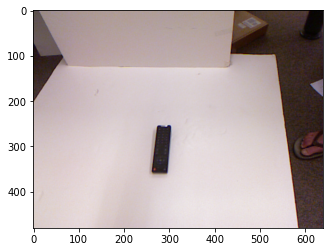

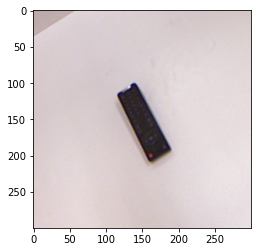

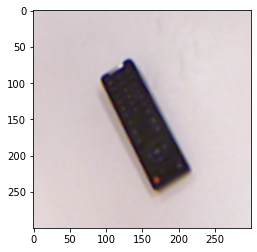

In [19]:
#测试一下前后的效果
from image_pro import Image

rgb_img = Image.from_file(rgbf[0])
plt.imshow(rgb_img.img)
plt.show()

#给图像应用旋转和裁剪
rgb_img.rotate(0.57,center)
rgb_img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))
plt.imshow(rgb_img.img)
plt.show()

rgb_img.zoom(0.6)
plt.imshow(rgb_img.img)

plt.show()

到这应该是可以算成功了的，但是有个问题，就是这个比例因子的大小范围是要仔细考虑的，首先放大肯定不行，算法里面这个坐标好像都算不出来，第二，太小的话，可能一幅图像里面都无法保证有一个完整的对象，这时候该如何标注呢？

## 4.对抓取类缩放功能的添加
就是直接照抄GGCNN里面，给Grasp这个类添加一个zoom函数

In [20]:
class Grasp:
    def __init__(self):
        pass
    
    def zoom(self,factor,center):
            '''
            功能：按照指定的缩放因子(factor)和中心点来缩放抓取矩形
            :参数：factor :缩放因子
            :参数：center :缩放中心
            '''
            #缩放矩阵定义
            T = np.array(
                [
                    [1/factor,0],
                    [0,1/factor]
                ]
            )
            c = np.array(center).reshape((1,2))

            self.points = ((np.dot(T,(self.points - c).T)).T+c).astype(np.int)

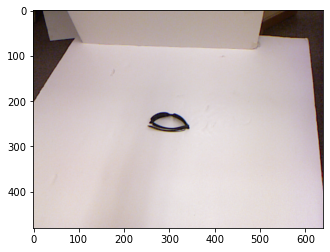

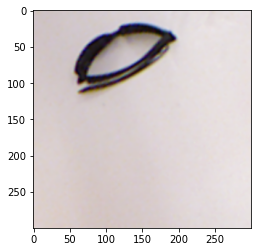

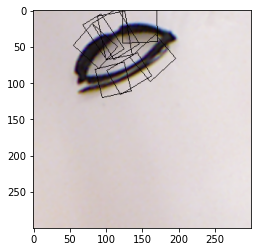

In [21]:
#读入原始图像
idx = 512
rgb_img = Image.from_file(rgbf[idx])
plt.imshow(rgb_img.img)
plt.show()

#读入原始抓取框
grs = Grasps.load_from_cornell_files(graspf[idx])
gr = grs.grs[0]

#给图像应用旋转,裁剪和缩放
rgb_img.rotate(0.57,center)
rgb_img.crop((top, left), (min(480, top + output_size), min(640, left + output_size)))
rgb_img.zoom(0.6)
plt.imshow(rgb_img.img)
plt.show()

#给抓取框应用旋转和平移并绘制结果
for gr in grs.grs:
    gr.rotate(0.57,center)
    gr.offset((-top,-left))
    gr.zoom(0.6,(output_size//2,output_size//2))
    for i in range(3):
        cv2.line(rgb_img.img,tuple(gr.points[i]),tuple(gr.points[i+1]),5)
    rgb_img.img = cv2.line(rgb_img.img,tuple(gr.points[3]),tuple(gr.points[0]),5) 

#展示结果
plt.imshow(rgb_img.img)
plt.show()

可以把前面代码里面的Image类改成DepthImage类，测试一下深度图像类的读取有没有问题。

这就好了，下面把这个功能添加到cornell的数据集里面去，然后测试一下没问题就行了，真的好久没有改动cornell_pro这个文件了

# 淦！

## 5.修改cornell数据集以满足增强后数据的正常训练

现在文件已经修改完了，太长了，不放在这，直接读入测试一下效果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


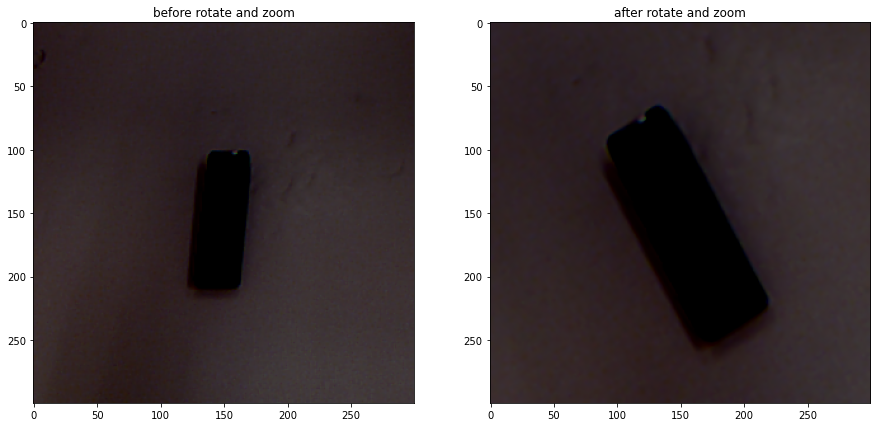

In [22]:
from cornell_pro import Cornell

dataset = Cornell('../cornell')
dataset_aug = Cornell('../cornell',random_rotate = True,random_zoom = True)

rgb_img = dataset.get_rgb(0)
rgb_img_aug = dataset_aug.get_rgb(0,0.57,0.6)

plt.figure(figsize = (15,15))
plt.subplot(121)
plt.title('before rotate and zoom')
plt.imshow(rgb_img)
plt.subplot(122)
plt.title('after rotate and zoom')
plt.imshow(rgb_img_aug)

plt.show()
#因为图像正则化过，像素值不是整数，所以后面有个红色的警告，这个没关系。

看上面的图像爱增强是正确的，下面看变换后的抓取框是否正确

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


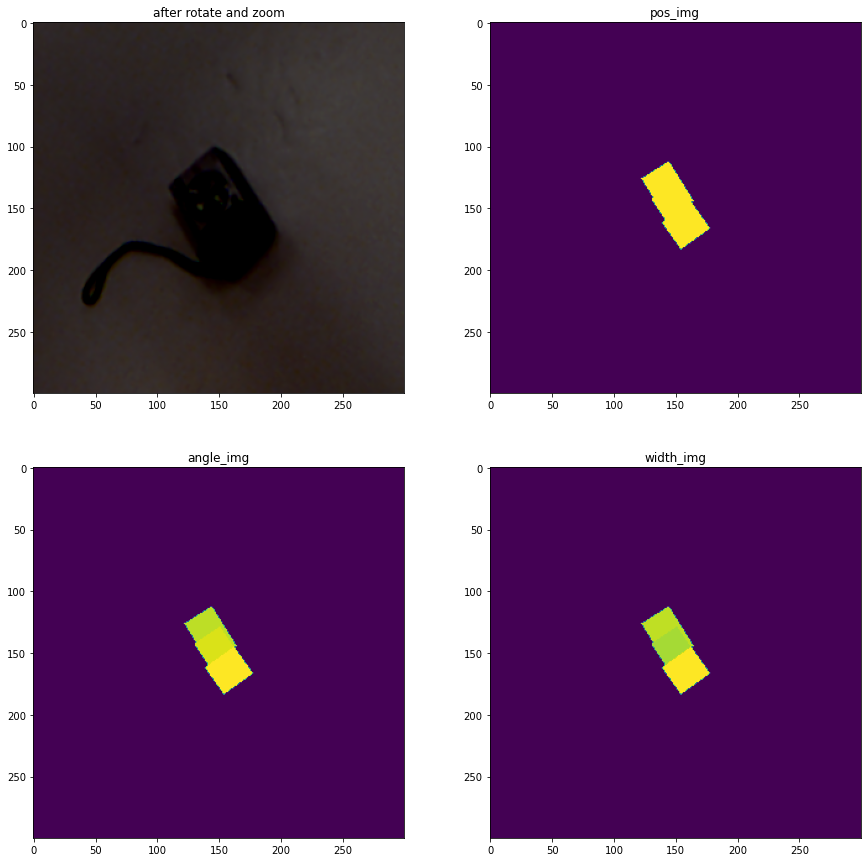

In [23]:
idx = 100
rot = 0.9
zoom_factor = 0.7

rgb_img_aug = dataset_aug.get_rgb(idx,rot,zoom_factor)
pos_img,angle_img,width_img = dataset_aug.get_grasp(idx,rot,zoom_factor)

plt.figure(figsize = (15,15))
plt.subplot(221)
plt.title('after rotate and zoom')
plt.imshow(rgb_img_aug)
plt.subplot(222)
plt.title('pos_img')
plt.imshow(pos_img)
plt.subplot(223)
plt.title('angle_img')
plt.imshow(angle_img)
plt.subplot(224)
plt.title('width_img')
plt.imshow(width_img)

plt.show()

结果很好，没有问题，下面开始训练试试，主函数和模型等部分完全没有改变，直接还是用原先的函数即可，就是更改了数据集而已，所以直接把原先的validate_main2.py拿过来，修改一下里面数据集部分的参数，添加random_rotate = True,random_zoom = True就行了。